# Model project: Cournot competition

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# Predefine options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 14})

# Model description

In this project we will analyse the cournot competiton model, where firms compete over quantity as opposed to price. This is a good description of industries where capacity is limited and quanity is less flexible than price in the short run. 

In a cournot duopoly, two firms operate in a market with homogenous goods and have identical production costs $c(q_i) = cq_i$, $i = 1,2$. Both firms choose their quantity $q_1, q_2$  simultanously, contributing to a total output of $Q = q_1 + q_2$. 

The firms face the following demand function:
$$ p(Q) = a-bQ $$

or stated in terms of residual demand:
$$ p(q_1,q_2) = a-bq_1 - bq_2$$ 

Each firm $i$ aims to maximize their profits given as:

$$ \pi_i = (a-bq_i - bq_j-c)q_i $$

where $q_j$ is the quantity of the competitor. They have complete information and must choose their optimal quantites given their beliefs about the competitor's action.

The model can be generalized to include $n$ firms, such that total output is given as $Q = q_1 + q_2 + ... + q_n$. Otherwise the model is identical to the case with two firms. Now the profit function is just given as:

$$ \pi_i = (a-bq_{-i} - bq_j-c)q_i $$

where $q_{-i} = Q-q_i$.

## Analytical solution

We will solve the cournot model with n firms for the more general result.

In [2]:
# Define all symbols
qi = sm.symbols('q_i')
qj = sm.symbols('q_{-i}')
a = sm.symbols('a')
b = sm.symbols('b')
c = sm.symbols('c')
n = sm.symbols('n')

In [3]:
# Profit function (we only need to define this once as the two firms are identical)
pi = (a-b*qi-b*qj-c)*qi
pi 

q_i*(a - b*q_i - b*q_{-i} - c)

We can solve the firms' maximazation problem in 3 steps:
> 1. Find the FOC of the profit function.
> 2. Find the best repsone function (BRF) by solving the FOC.
> 3. Find the equilibirum by solving the linear equation system of BRF's.

**1.FOC of the profit function**

In [4]:
foc = sm.diff(pi, qi)
foc

a - 2*b*q_i - b*q_{-i} - c

**2. BRF for firm i**

In [5]:
BRF = sm.solve(sm.Eq(foc,0), qi)
BRF[0]

(a - b*q_{-i} - c)/(2*b)

**3. Equilibrium**

Since the firms are identical the equillibrium quantites must be equal: $q_{-i}^* = (n-1)q_i^*$, why we can simply solve one firm's BRF by inserting this.

In [6]:
# Equilibrium
BRF = BRF[0]
eq_qj = (n-1)*qi

BRF_subs = BRF.subs(qj, eq_qj)
BRF_subs

eq_qi = sm.solve(sm.Eq(BRF_subs,qi), qi)
eq_qi[0]

(a - c)/(b*(n + 1))

Now that we have found the equilibrium quantity we can find the equilibirum price and profit:

In [7]:
eq_p = a-b*n*eq_qi[0]
eq_p

a - n*(a - c)/(n + 1)

In [8]:
eq_pi = (eq_p-c)*eq_qi[0]
eq_pi

(a - c)*(a - c - n*(a - c)/(n + 1))/(b*(n + 1))

In [10]:
# Create python functions from solution
qi_func = sm.lambdify(args=(a,b,c,n),expr=eq_qi[0])
p_func = sm.lambdify(args=(a,b,c,n),expr=eq_p)
pi_func = sm.lambdify(args=(a,b,c,n),expr=eq_pi)

## Numerical solution

Now we can solve the model numerically using the same steps as in the analystical solution. To solve the model we create a class for a cournot model with $n$ firms and identical cost functions.

In [11]:
class cournot_n:
    
    # Set parameters
    def __init__(self, a, b, c, n):
        self.a = a
        self.b = b
        self.c = c
        self.n = n
    
    # Define profit function
    def profit(self, qi, q_min_i):
        return (self.a - self.b*(qi+q_min_i) - self.c)*qi
    
    # Find BRF by maximizing the profit function.
    def BRF(self, q_min_i):
        x = optimize.minimize(lambda x: -self.profit(x, q_min_i), x0=0, method='SLSQP')
        return max(x.x[0],0)
    
    # solve BRF equation system. 
    # Set up equation system. Here we again simplify the problem to one firm by imposing that q_(-i)= (n-1)q_i.
    def BRFs(self, q):
        y = np.zeros(2)
        y[0] = q[0] - self.BRF(q[1])
        y[1] = (self.n-1)*q[0] - q[1]
        return y
    
    # Find the roots of the equation system (illustrative and interactive inital quess)
    def sol(self, x0):
        res = optimize.root(self.BRFs, x0)
        success = res.success
        return success

    # Find equillibrium values
    def EQ(self):
        x0 = np.array([0,0])
        res = optimize.root(self.BRFs, x0)
        
        # Return equillibrium quantity, price and profit.
        qi_star = res.x[0]
        p_star = self.a - self.b*self.n*qi_star
        pi_star = (p_star - self.c)*qi_star

        return [qi_star, p_star, pi_star]

Now we can test wheter the optimazation works by creating a cournot model with specific parameters from the class and calling the optimizer and checking that it converges for different starting values.

In [52]:
# Create cournot model
test=cournot_n(25,5,5,3)

# Random starting value
starting_values = [[0,0], [15,76], [-34,107], [-1000,1000]]

# Check convergence
convergence = []

for x in starting_values:
    res = test.sol(x)
    convergence.append(res)

print(convergence)

[True, True, True, True]


Now we can find the equilibirum values and compare them with the analytical solution to check the numerical optimizer finds the correct solution.

In [53]:
# Numerical solution
res = test.EQ()

print (f'qi_star = {res[0]:.3f}')
print(f'p_star = {res[1]:.3f}')
print(f'pi_star = {res[2]:.3f}')

qi_star = 1.000
p_star = 10.000
pi_star = 5.000


In [54]:
# Analytical solution (lambda functions)
res2 = [qi_func(25,5,5,3), p_func(25,5,5,3), pi_func(25,5,5,3)]

print (f'qi_star = {res2[0]}')
print(f'p_star = {res2[1]}')
print(f'pi_star = {res2[2]}')

qi_star = 1.0
p_star = 10.0
pi_star = 5.0


As we can see the two are identical.

# Further analysis

Now we will look into how the model changes with the paramter values c and n.

In [58]:
# Define empty list to store solutions
costs = []
temp = []
firms = []
temp2 = []

for c in range(0,26):
    model = cournot_n(25,5,c,2)
    x =  model.EQ()
    costs.append(c)
    temp.append(x)

for n in range(1,26):
    model = cournot_n(25,5,5,n)
    x =  model.EQ()
    firms.append(n)
    temp2.append(x)

# Transform lists into arrays for latter use
diff_c = np.array(temp)
diff_n = np.array(temp2)


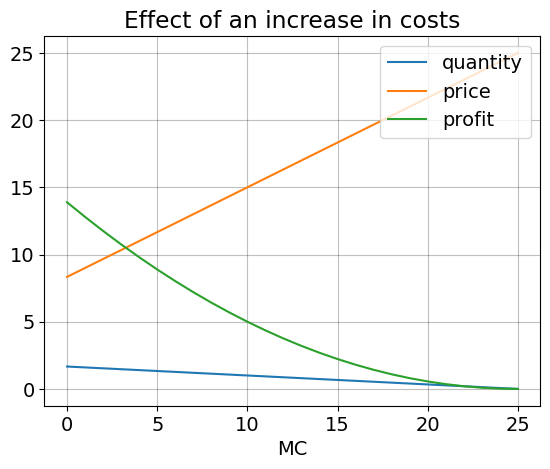

In [60]:
# Create the figure
fig = plt.figure()

# Plot
ax = fig.add_subplot(1,1,1)

ax.plot(costs,diff_c[:,0], label='quantity')
ax.plot(costs,diff_c[:,1],label='price')
ax.plot(costs,diff_c[:,2],label='profit')


ax.set_title('Effect of an increase in costs')
ax.set_xlabel('MC');
ax.legend(loc='upper right');

As we can see from the figure, when the marginal cost increases the profit and quantity goes towards zero, while the price increases until it is no longer profitable to produce on the market. 

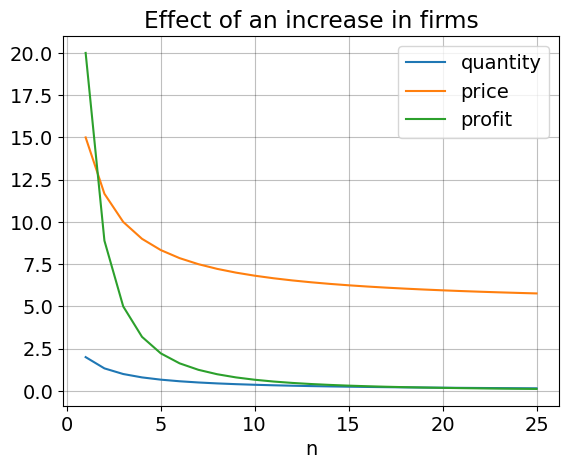

In [61]:
# Create the figure
fig = plt.figure()

# Plot
ax = fig.add_subplot(1,1,1)

ax.plot(firms,diff_n[:,0], label='quantity')
ax.plot(firms,diff_n[:,1],label='price')
ax.plot(firms,diff_n[:,2],label='profit')

ax.set_title('Effect of an increase in firms')
ax.set_xlabel('n');
ax.legend(loc='upper right');

As we can see from the figure, the equillibrium profit and quanity for firm $i$ goes towards zero when n increases and the price converges to the marginal cost. As such when the number of firms goes towards infinity the model converges to perfect competition.

**Extension**

One way to extend the model is to introduce assymetric marginal costs. Here we will reduce the model to a duopoly again and solve it following the same procedure as before.

In [62]:
class assym_cournot:
    def __init__(self, a, b, c1, c2):
        self.a = a
        self.b = b
        self.c1 = c1
        self.c2 = c2
    
    # Profit
    def profit_1(self, q1, q2):
        return (self.a - self.b*(q1+q2) - self.c1)*q1
    
    def profit_2(self, q1, q2):
        return (self.a - self.b*(q1+q2) - self.c2)*q2
    
    # BR functions
    def BR_1(self, q2):
        x = optimize.minimize(lambda x: -self.profit_1(x, q2), x0=0, method='SLSQP')
        return max(x.x[0],0)
    
    def BR_2(self, q1):
        x = optimize.minimize(lambda x: -self.profit_2(q1, x), x0=0, method='SLSQP')
        return max(x.x[0],0)
    
    # Solve BR equation system
    def BRs(self, q):
        y = np.zeros(2)
        y[0] = q[0] - self.BR_1(q[1])
        y[1] = q[1] - self.BR_2(q[0])
        return y
    
    # Find the roots of the equation system (illustrative)
    def sol(self):
        x0 = np.array([0,0])
        res = optimize.root(self.BRs, x0)
        return res

    # Find equillibrium values
    def EQ(self):
        res = self.sol()

        # Return equillibrium quantity, price and profit.
        q1_star = res.x[0]
        q2_star = res.x[1]
        p_star = self.a - self.b*(q1_star+q2_star)
        pi1_star = (p_star - self.c1)*q1_star
        pi2_star = (p_star - self.c2)*q2_star

        return [q1_star, q2_star, p_star, pi1_star, pi2_star]

In [63]:
# Test to see if optimizer converges
test2 = assym_cournot(50,5,4,1)
test2.sol()

 message: The solution converged.
 success: True
  status: 1
     fun: [ 0.000e+00 -4.441e-16]
       x: [ 2.867e+00  3.467e+00]
    nfev: 5
    fjac: [[-8.944e-01 -4.472e-01]
           [ 4.472e-01 -8.944e-01]]
       r: [-1.118e+00 -8.944e-01 -6.708e-01]
     qtf: [-1.375e-11 -5.072e-12]

Now that we have defined the class, we can find how the solution changes when the difference between the two firms' marginal costs increases.

In [64]:
# Define empty list to store solutions
costs_1 = []
temp3 = []

for c in range(1,51,2):
    model2 = assym_cournot(50,5,c,1)
    x =  model2.EQ()
    costs_1.append(c)
    temp3.append(x)

# Transform lists into arrays for latter use
diff_c1 = np.array(temp3)
cost_diff = np.array(costs_1)-1

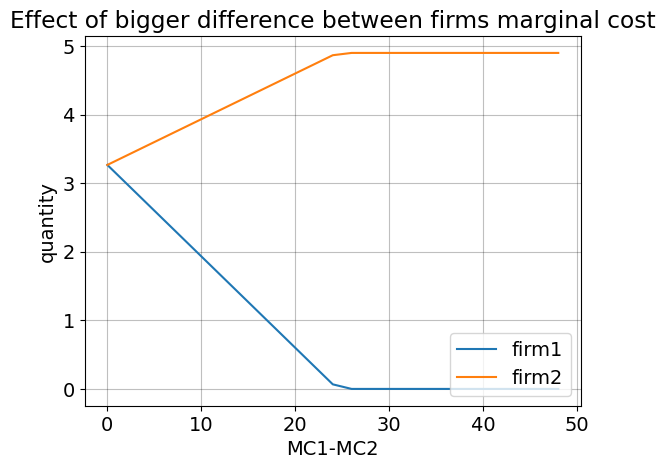

In [65]:
# Create the figure
fig = plt.figure()

# Plot
ax = fig.add_subplot(1,1,1)

ax.plot(cost_diff,diff_c1[:,0], label='firm1')
ax.plot(cost_diff,diff_c1[:,1], label='firm2')

ax.set_title('Effect of bigger difference between firms marginal cost')
ax.set_ylabel('quantity');
ax.set_xlabel('MC1-MC2');
ax.legend(loc='lower right');

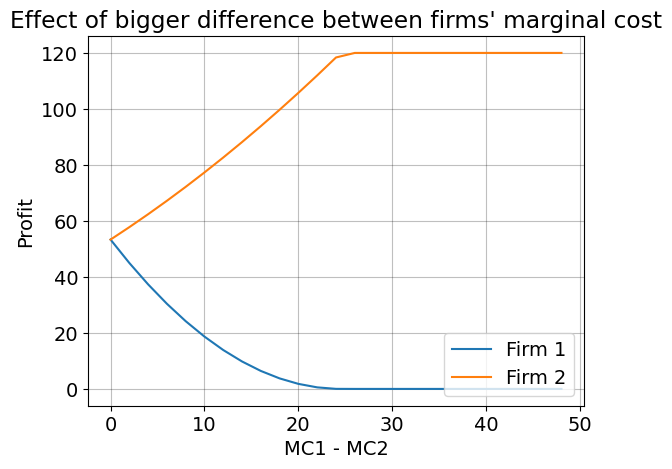

In [66]:
# Create the figure
fig = plt.figure()

# Plot
ax = fig.add_subplot(1,1,1)

ax.plot(cost_diff,diff_c1[:,3], label='Firm 1')
ax.plot(cost_diff,diff_c1[:,4], label='Firm 2')

ax.set_title("Effect of bigger difference between firms' marginal cost")
ax.set_xlabel('MC1 - MC2');
ax.set_ylabel('Profit')
ax.legend(loc='lower right');

As can be seen from both figures, when the difference between marginal costs increases the firm with the higher MC experiences lower quantity sold and therefore lower profit until it is no longer profitable to operate on the market. As such, the market rewards relative effeciency and pushes high production cost firms out of the market even under minimal competition.

# Conclusion

The cournot model demonstrates how market structures affect competition and consumer welfare. As seen in the first version of the model, more firms lead to better consumer welfare with lower prices and higher quantities. The model also suggests, that firms facing higher production costs may exit the market over time due to competition from more efficient competitors, as seen in the second version of the model. In this way the cournot model highlights the importance of promoting competitive markets to enhance consumer welfare and economic efficiency.